# divide observations into watermasses based on location
## in this file our cuttoff of latitudes follows the definitions of the nothern CCS in Checkley & Barth 2009

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import interpn
import cmocean as cm
import gsw
import datetime as dt
from scipy.stats import pearsonr

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

# for ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

# for anova
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [3]:
obs = obs[(obs['latitude (degrees_north)']>=40) & (obs['latitude (degrees_north)']<=50.8)].reset_index() # decreases from 1006797 to 883969
obs.drop(columns=['index','Unnamed: 0.1','Unnamed: 0'],inplace=True)


In [4]:
set(obs.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI Coastal, NHL',
 'NCEI PNW',
 'NCEI Salish',
 'NHL',
 'OCNMS',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios bottle, NCEI PNW, GEOTRACES',
 'ios ctd profiles',
 'ios ctd profiles, ios bottle',
 'ios mooring',
 'ios mooring, ios bottle',
 'ooi'}

In [6]:
# can't believe you haven't made a density column yet 
CT = gsw.CT_from_t(obs['salinity (g kg-1)'],obs['temperature (degC)'],obs['pressure (dbar)'])
rho = gsw.rho_alpha_beta(np.array(obs['salinity (g kg-1)']), CT, np.array(obs['pressure (dbar)']))[0]
obs['density (kg m-3)'] = rho

In [7]:
# can we be smarter about date division
# transition dates based on Bakun index analysis  
fall = pd.to_datetime(['1967-09-28T00:00:00.000000000', '1968-10-08T00:00:00.000000000',
       '1969-09-15T00:00:00.000000000', '1970-10-13T00:00:00.000000000',
       '1971-10-17T00:00:00.000000000', '1972-10-29T00:00:00.000000000',
       '1973-10-14T00:00:00.000000000', '1974-11-02T00:00:00.000000000',
       '1975-09-29T00:00:00.000000000', '1976-10-22T00:00:00.000000000',
       '1977-10-19T00:00:00.000000000', '1978-11-13T00:00:00.000000000',
       '1979-10-16T00:00:00.000000000', '1980-10-21T00:00:00.000000000',
       '1981-09-19T00:00:00.000000000', '1982-10-04T00:00:00.000000000',
       '1983-10-17T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1985-10-17T00:00:00.000000000', '1986-10-20T00:00:00.000000000',
       '1987-11-06T00:00:00.000000000', '1988-10-26T00:00:00.000000000',
       '1989-10-15T00:00:00.000000000', '1990-10-16T00:00:00.000000000',
       '1991-10-31T00:00:00.000000000', '1992-10-15T00:00:00.000000000',
       '1993-11-22T00:00:00.000000000', '1994-10-21T00:00:00.000000000',
       '1995-11-05T00:00:00.000000000', '1996-10-01T00:00:00.000000000',
       '1997-09-24T00:00:00.000000000', '1998-10-09T00:00:00.000000000',
       '1999-10-21T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2001-10-24T00:00:00.000000000', '2002-11-03T00:00:00.000000000',
       '2003-10-04T00:00:00.000000000', '2004-10-30T00:00:00.000000000',
       '2005-09-30T00:00:00.000000000', '2006-10-31T00:00:00.000000000',
       '2007-09-28T00:00:00.000000000', '2008-09-22T00:00:00.000000000',
       '2009-10-11T00:00:00.000000000', '2010-09-22T00:00:00.000000000',
       '2011-09-16T00:00:00.000000000', '2012-10-11T00:00:00.000000000',
       '2013-11-03T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
       '2015-10-06T00:00:00.000000000', '2016-10-02T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2019-11-06T00:00:00.000000000', '2020-11-11T00:00:00.000000000',
       '2021-09-15T00:00:00.000000000', '2022-10-24T00:00:00.000000000',
       '2023-09-22T00:00:00.000000000'], utc=True)
spring =pd.to_datetime(['1967-03-27T00:00:00.000000000', '1968-03-26T00:00:00.000000000',
       '1969-04-26T00:00:00.000000000', '1970-03-15T00:00:00.000000000',
       '1971-04-13T00:00:00.000000000', '1972-03-21T00:00:00.000000000',
       '1973-03-19T00:00:00.000000000', '1974-04-08T00:00:00.000000000',
       '1975-03-21T00:00:00.000000000', '1976-04-09T00:00:00.000000000',
       '1977-03-11T00:00:00.000000000', '1978-03-07T00:00:00.000000000',
       '1979-03-14T00:00:00.000000000', '1980-03-01T00:00:00.000000000',
       '1981-03-24T00:00:00.000000000', '1982-03-03T00:00:00.000000000',
       '1983-04-01T00:00:00.000000000', '1984-04-18T00:00:00.000000000',
       '1985-02-14T00:00:00.000000000', '1986-03-26T00:00:00.000000000',
       '1987-03-12T00:00:00.000000000', '1988-04-05T00:00:00.000000000',
       '1989-04-04T00:00:00.000000000', '1990-03-25T00:00:00.000000000',
       '1991-04-08T00:00:00.000000000', '1992-03-04T00:00:00.000000000',
       '1993-04-26T00:00:00.000000000', '1994-03-23T00:00:00.000000000',
       '1995-03-22T00:00:00.000000000', '1996-04-25T00:00:00.000000000',
       '1997-03-30T00:00:00.000000000', '1998-02-21T00:00:00.000000000',
       '1999-03-29T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2001-02-21T00:00:00.000000000', '2002-03-22T00:00:00.000000000',
       '2003-04-11T00:00:00.000000000', '2004-03-29T00:00:00.000000000',
       '2005-05-22T00:00:00.000000000', '2006-04-18T00:00:00.000000000',
       '2007-03-11T00:00:00.000000000', '2008-03-27T00:00:00.000000000',
       '2009-03-03T00:00:00.000000000', '2010-04-04T00:00:00.000000000',
       '2011-03-29T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2013-03-19T00:00:00.000000000', '2014-03-20T00:00:00.000000000',
       '2015-02-12T00:00:00.000000000', '2016-03-23T00:00:00.000000000',
       '2017-04-22T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2019-04-06T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2021-03-19T00:00:00.000000000', '2022-04-20T00:00:00.000000000',
       '2023-04-22T00:00:00.000000000'], utc=True)

In [8]:
# first lets work with the data covered by the Bakun index
obs['time'] = pd.to_datetime(obs.time)
obs['season'] = 'none'
for i in range(len(spring)):
    obs.season[(obs.time-spring[i]>=dt.timedelta(days=0)) & (obs.time-fall[i]<dt.timedelta(days=0))] = 'up'
for i in range(len(spring)-1):
    obs.season[(obs.time-spring[i+1]<dt.timedelta(days=0)) & (obs.time-fall[i]>=dt.timedelta(days=0))] = 'down'


# then for the data before then choose a conservative split
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & ((obs.month >=11) | (obs.month <=2))] = 'down'
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & (obs.month >= 5) & (obs.month <=8)] = 'up'

In [9]:
obs['region'] = 'none'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']>=120)] = 'offshore deep'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']<120)] = 'offshore surface'
obs.region[(obs.location == 'shelf') & (obs['salinity (g kg-1)'] > 31.5) & (obs['latitude (degrees_north)'] >= 49)] = 'north'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] > 31.5)] = 'south'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -129.2) & (obs['latitude (degrees_north)'] >= 49) & (obs['depth (m)'] <= 200) & (obs['salinity (g kg-1)'] > 31.5)] = 'north'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -128.8) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5) & (obs['depth (m)'] <=200)] = 'south'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -128.8) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7) & (obs['salinity (g kg-1)'] > 31.5)] = 'cuc'
obs.region[(obs.location == 'shelf') & (obs['salinity (g kg-1)'] <= 31.5) & (obs['latitude (degrees_north)'] <= 47.3)] = 'brackish'

In [10]:
sources = ['ios bottle','ios mooring','ios ctd profiles','NCEI Coastal','NCEI PNW','NHL','ooi','GEOTRACES','OCNMS']
source_name = ['IOS Bottle','IOS Mooring','IOS CTD','NCEI Coastal','NCEI PNW','NHL','OOI Washington','GEOTRACES','OCNMS']

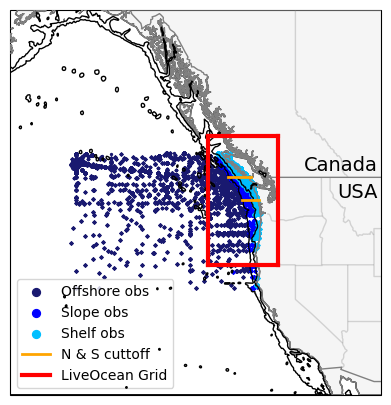

In [ ]:
# plot of all observations

xlim, ylim = [-152.5, -110.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(5,5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=5))
ax.add_feature(feature.BORDERS, edgecolor='gray', zorder=3)
ax.add_feature(feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines',scale='50m',facecolor='none'), edgecolor='gray', alpha=0.3, zorder=3)


# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='none', edgecolor='k',zorder=6))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='none', edgecolor='k',zorder=6))

# plot all the points
ax.scatter(obs['longitude (degrees_east)'][(obs.location == 'offshore')],obs['latitude (degrees_north)'][(obs.location == 'offshore')], transform=crs.PlateCarree(),s=2,zorder=4,color='midnightblue',label='Offshore obs')
ax.scatter(obs['longitude (degrees_east)'][(obs.location == 'slope')&(obs['longitude (degrees_east)']> -128.8)],obs['latitude (degrees_north)'][(obs.location == 'slope')&(obs['longitude (degrees_east)']> -128.8)], transform=crs.PlateCarree(),s=2,zorder=4,color='blue',label='Slope obs')
ax.scatter(obs['longitude (degrees_east)'][(obs.location == 'shelf')&(obs['longitude (degrees_east)']> -129.2)],obs['latitude (degrees_north)'][(obs.location == 'shelf')&(obs['longitude (degrees_east)']> -129.2)], transform=crs.PlateCarree(),s=2,zorder=4,color='deepskyblue',label='Shelf obs')

#north cuttoff
ax.plot([-127.7,-125],[49,49], color='orange', transform=crs.PlateCarree(),zorder=7,lw=2,)
# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], color='orange', transform=crs.PlateCarree(),zorder=7,lw=2,label='N & S cuttoff')

# LiveOcean grid
ax.plot([grid.lon_rho[0,0].values,grid.lon_rho[0,0].values],[grid.lat_rho[0,0].values,grid.lat_rho[-1,0].values],'r',transform=crs.PlateCarree(),lw=3,label='LiveOcean Grid',zorder=6)
ax.plot([grid.lon_rho[0,-1].values,grid.lon_rho[0,-1].values],[grid.lat_rho[0,0].values,grid.lat_rho[-1,0].values],'r',transform=crs.PlateCarree(),lw=3,zorder=6)
ax.plot([grid.lon_rho[0,-1].values,grid.lon_rho[0,0].values],[grid.lat_rho[-1,0].values,grid.lat_rho[-1,0].values],'r',transform=crs.PlateCarree(),lw=3,zorder=6)
ax.plot([grid.lon_rho[0,0].values,grid.lon_rho[0,-1].values],[grid.lat_rho[0,0].values,grid.lat_rho[0,0].values],'r',transform=crs.PlateCarree(),lw=3,zorder=6)

# label canada and the USA
ax.text(0.99, .5, 'USA', ha='right', va='bottom', transform=ax.transAxes, fontsize=14)
ax.text(0.99, 0.62, 'Canada', ha='right', va='top', transform=ax.transAxes, fontsize=14)

ax.legend(loc='lower left',markerscale=4)

plt.savefig('insetmap.jpg')

In [ ]:
wob = obs[obs.season == 'down'] # downwelling observations
sob = obs[obs.season == 'up'] # upwelling observations

## Functions

In [19]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax, x, y):
    smin, smax = 28.2,36.6
    tmin = np.nanmean(df[y]) - 4*np.nanstd(df[y])
    tmax = np.nanmean(df[y]) + 4*np.nanstd(df[y])

    salt = df[x][df.region == region].reset_index(drop=True)
    temp = df[y][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(temp[~np.isnan(temp)]))
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [ ]:
############
# ELLIPSES #
############

def percentile_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, **kwargs)

    # Add the ellipse to the plot
    # ax.add_patch(ellipse)
    # return subset_mean[0], subset_mean[1], width, height, angle
    return ellipse
    

In [21]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,regions,property,ax,**kwargs):
    tracer = [df[property][df.region==region] for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ticks = [str(len(t_filter[i])) for i in range(len(regions))]
    ax.set_xticklabels(ticks,rotation=30,ha='right',fontsize=9)
    ax.set_ylabel(property)

    return bplot

In [22]:
# which tracers come from which sources
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

 
for prop in properties:
    print(prop)
    print(list(set(obs.source[~np.isnan(obs[prop])])))
    print("\n")

temperature (degC)
['NCEI Coastal, NHL', 'ooi', 'ios bottle', 'OCNMS', 'ios mooring, ios bottle', 'NCEI Salish', 'ios mooring', 'ios bottle, NCEI PNW, GEOTRACES', 'ios bottle, GEOTRACES', 'ios ctd profiles', 'NCEI PNW', 'ios ctd profiles, ios bottle', 'ios bottle, NCEI PNW', 'NCEI Coastal', 'NHL']


salinity (g kg-1)
['NCEI Coastal, NHL', 'ooi', 'ios bottle', 'OCNMS', 'ios mooring, ios bottle', 'NCEI Salish', 'ios mooring', 'ios bottle, NCEI PNW, GEOTRACES', 'ios bottle, GEOTRACES', 'ios ctd profiles', 'ios ctd profiles, ios bottle', 'NCEI PNW', 'ios bottle, NCEI PNW', 'NCEI Coastal', 'NHL']


DO (umol kg-1)
['NCEI Coastal, NHL', 'ooi', 'ios bottle', 'OCNMS', 'ios mooring, ios bottle', 'NCEI Salish', 'ios mooring', 'ios bottle, NCEI PNW, GEOTRACES', 'ios bottle, GEOTRACES', 'NCEI PNW', 'ios ctd profiles', 'ios ctd profiles, ios bottle', 'ios bottle, NCEI PNW', 'NCEI Coastal', 'NHL']


NO3 (uM)
['NCEI Coastal, NHL', 'ooi', 'ios bottle', 'NCEI Salish', 'ios bottle, NCEI PNW, GEOTRACES', 

## Summer

In [23]:
# count the number of observations for each variable
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

for reg in regions:
    print(reg)
    for prop in properties:
        print("{}= {}".format(prop,len(sob[(sob.region == reg) & ~np.isnan(sob[prop])])))
        # print(list(set(sob.source[(sob.region == reg) & ~np.isnan(sob[prop])])))
    print("\n")

offshore deep
temperature (degC)= 91293
salinity (g kg-1)= 112755
DO (umol kg-1)= 79491
NO3 (uM)= 4447
NO2 (uM)= 193
NH4 (uM)= 92
PO4 (uM)= 4796
SiO4 (uM)= 4769
TA (umol/kg)= 176
DIC (umol/kg)= 173
Carbonate (umol/kg)= 38
Aragonite= 163
Calcite= 163
Cd (nmol kg-1)= 152
Co (nmol kg-1)= 152
Cu (nmol kg-1)= 152
Fe (nmol kg-1)= 152
Mn (nmol kg-1)= 152
Ni (nmol kg-1)= 152
Zn (nmol kg-1)= 151


offshore surface
temperature (degC)= 44578
salinity (g kg-1)= 70482
DO (umol kg-1)= 38745
NO3 (uM)= 8841
NO2 (uM)= 326
NH4 (uM)= 157
PO4 (uM)= 8942
SiO4 (uM)= 8422
TA (umol/kg)= 320
DIC (umol/kg)= 303
Carbonate (umol/kg)= 56
Aragonite= 291
Calcite= 291
Cd (nmol kg-1)= 219
Co (nmol kg-1)= 219
Cu (nmol kg-1)= 219
Fe (nmol kg-1)= 219
Mn (nmol kg-1)= 219
Ni (nmol kg-1)= 219
Zn (nmol kg-1)= 218


cuc
temperature (degC)= 86258
salinity (g kg-1)= 99254
DO (umol kg-1)= 74638
NO3 (uM)= 5857
NO2 (uM)= 908
NH4 (uM)= 775
PO4 (uM)= 5913
SiO4 (uM)= 5775
TA (umol/kg)= 1010
DIC (umol/kg)= 1013
Carbonate (umol/kg)= 27

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

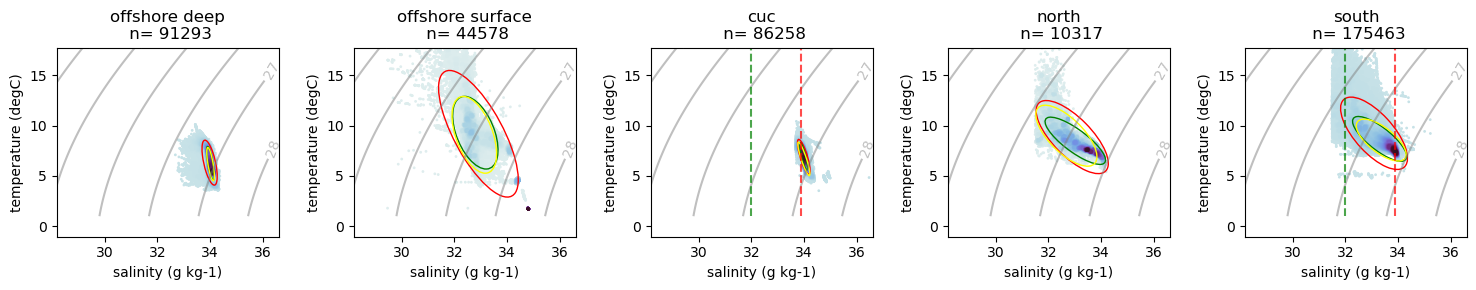

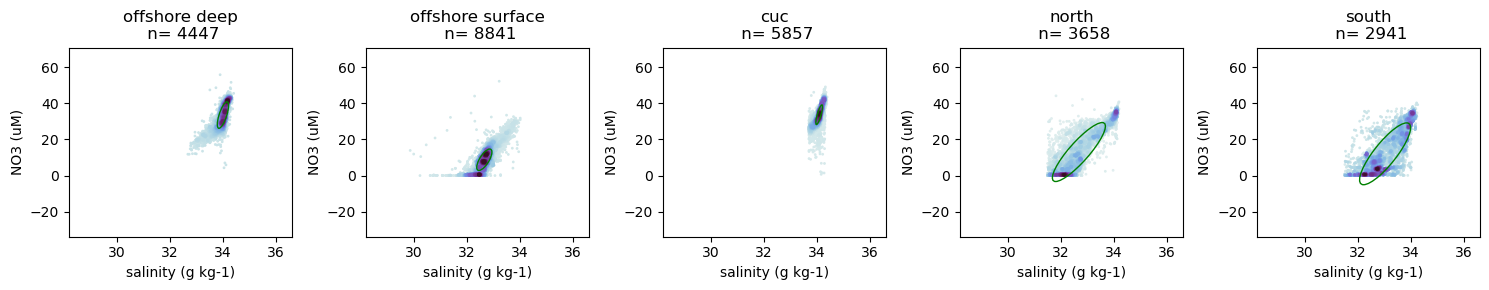

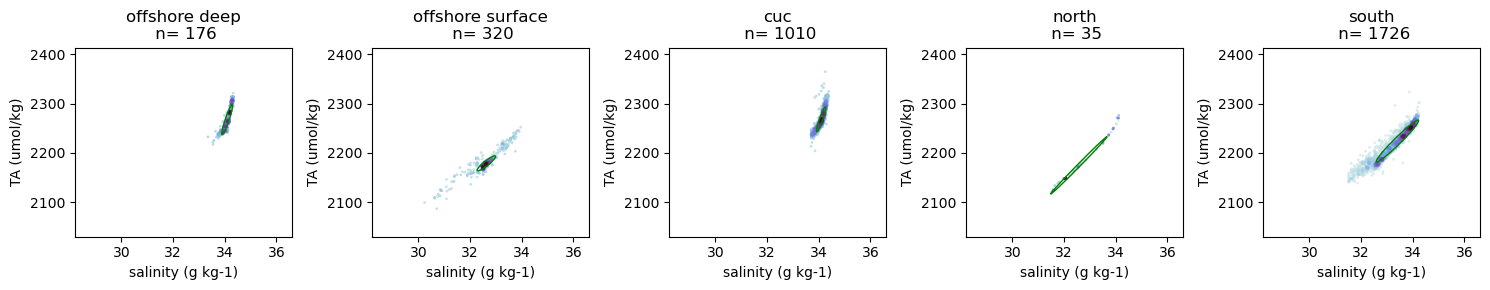

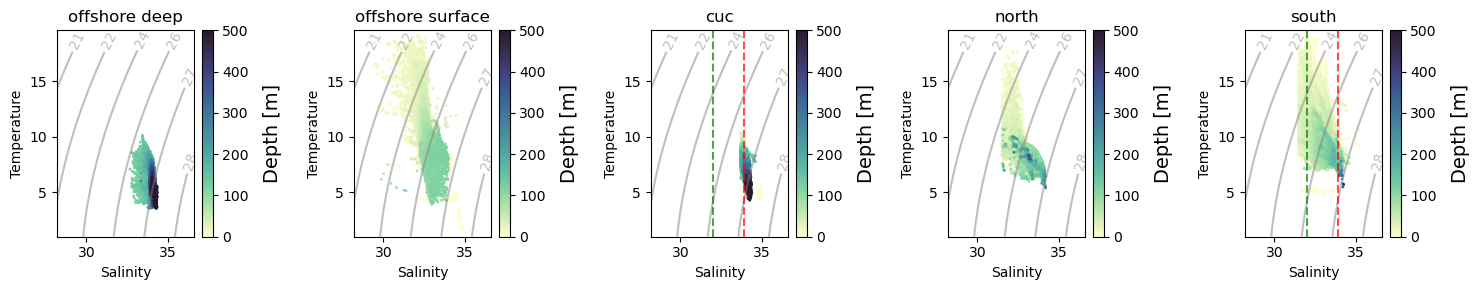

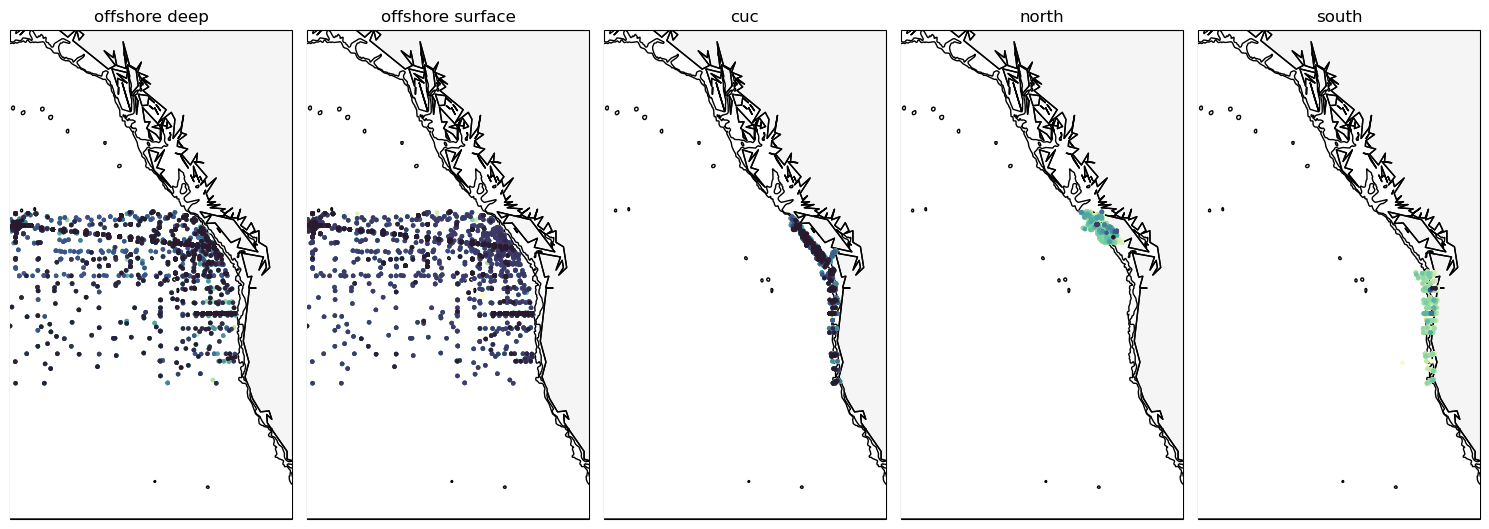

In [ ]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
# x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, facecolor='none',edgecolor='green')
    ax[i].add_patch(ell)


# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information
NSx_mean, NSy_mean, NSwidth, NSheight, NSangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['NO3 (uM)'][sob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TA - Salinity
#elipse information
TASx_mean, TASy_mean, TASwidth, TASheight, TASangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','TA (umol/kg)')
    ell = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['TA (umol/kg)'][sob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TS coloured by depth
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS_depth(sob,regions[i],ax[i])

# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*3,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(sob,regions[i],ax[i])
plt.tight_layout()

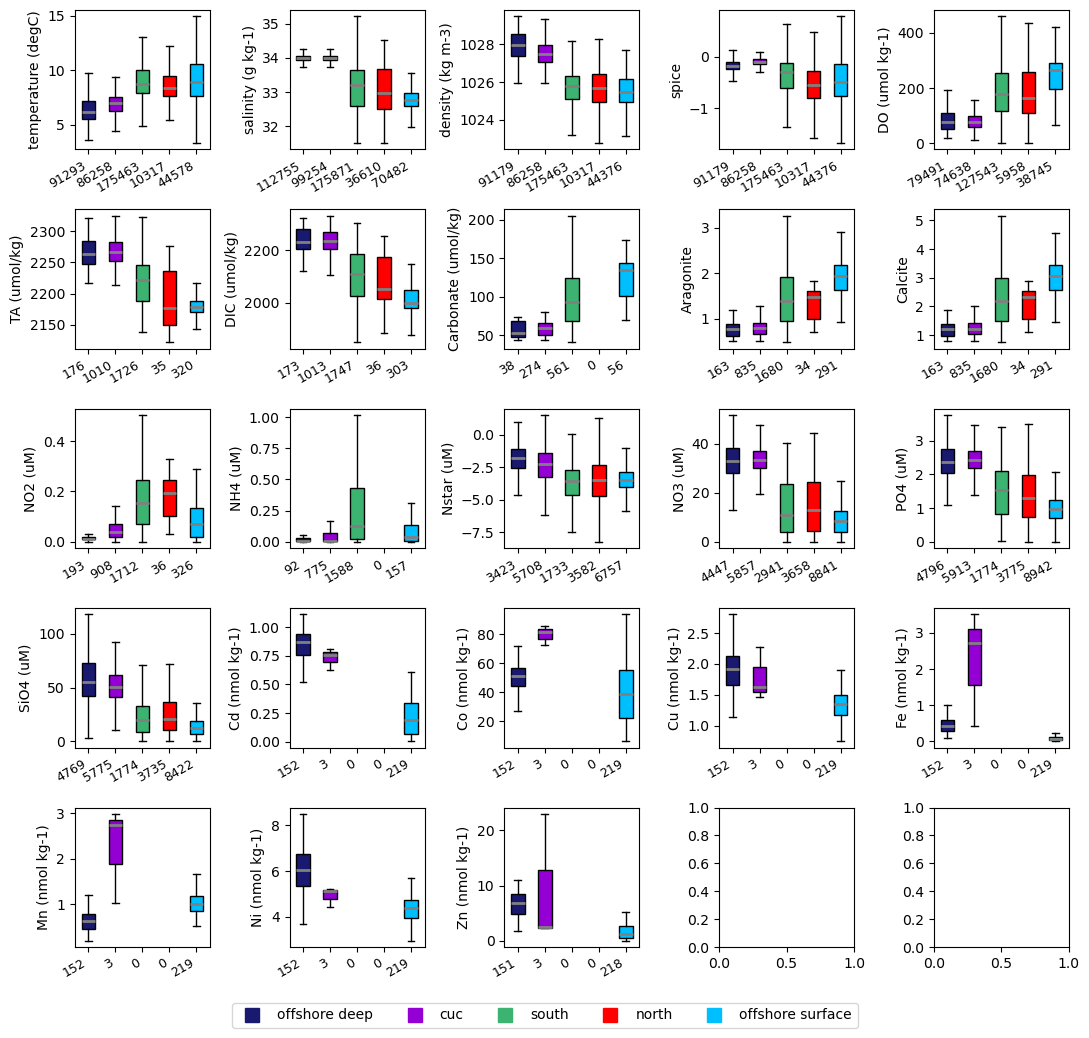

In [26]:
# box plots of different tracers
regions = ['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
colour = ['midnightblue','darkviolet','mediumseagreen','red','deepskyblue']

fig, ax = plt.subplots(5,5,figsize=[11,10])

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[0,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['TA (umol/kg)','DIC (umol/kg)','Carbonate (umol/kg)','Aragonite', 'Calcite']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[1,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['NO2 (uM)','NH4 (uM)','Nstar (uM)','NO3 (uM)','PO4 (uM)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[2,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# ## To indicate significance
# ax[1,0].plot([1, 1, 3, 3], [52, 54, 54, 49], linewidth=1, color='grey')
# ax[1,0].text(2, 47, "*", ha='center', va='bottom', color='grey',fontsize=10)
# ax[1,0].plot([4, 4, 5, 5], [0, -2, -2, 0], linewidth=1, color='grey')
# ax[1,0].text(4.5, -4, "*", ha='center', va='bottom', color='grey',fontsize=10)


properties = ['SiO4 (uM)', 'Cd (nmol kg-1)','Co (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[3,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[4,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# build legend handles    
legend_handles = []
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor=colour[i], markerfacecolor=colour[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.001), frameon=True)

plt.tight_layout()
    


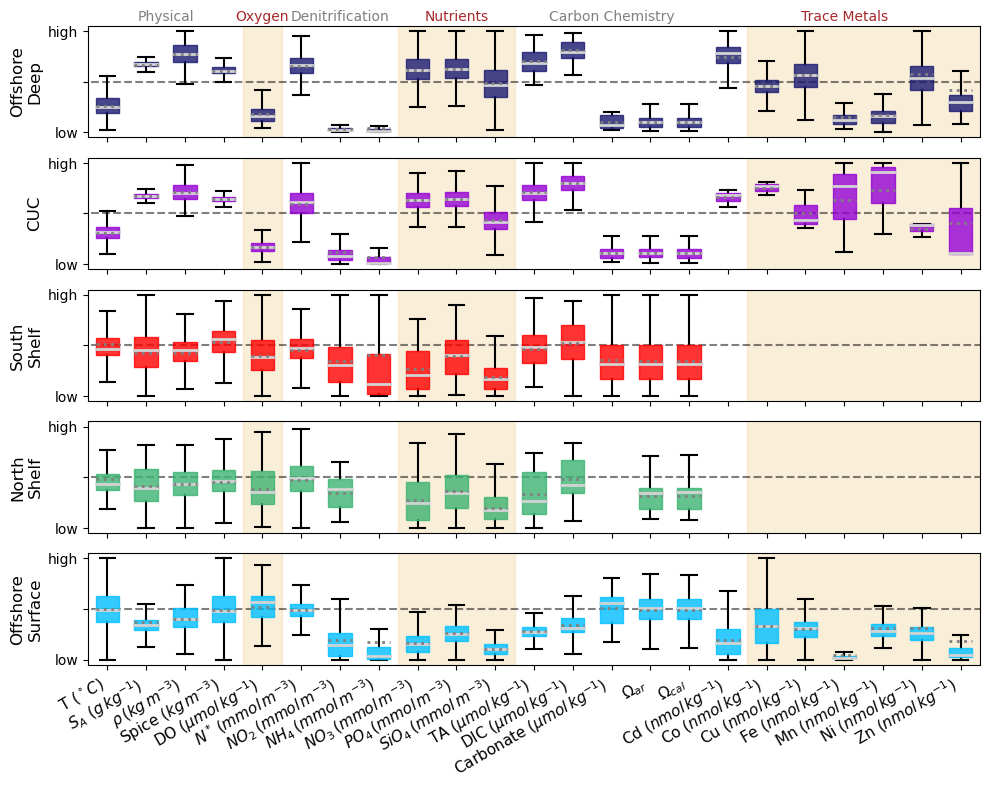

In [27]:
regions = ['offshore deep','cuc','south','north','offshore surface']
colour = ['midnightblue','darkviolet',  'r', 'mediumseagreen', 'deepskyblue']

data = sob
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)','Carbonate (umol/kg)','Aragonite', 'Calcite','Cd (nmol kg-1)','Co (nmol kg-1)',
              'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='lightgrey', linewidth=2,zorder=4)  # Median
        ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='grey', ls='dotted', linewidth=2,zorder=4)  # Mean

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              '$N^* \,(mmol\,m^{-3}$)','$NO_2\,(mmol\,m^{-3})$','$NH_4\,(mmol\,m^{-3})$','$NO_3\,(mmol\,m^{-3})$', '$PO_4\,(mmol\,m^{-3})$', '$SiO_4\,(mmol\,m^{-3})$', 'TA ($\mu mol\,kg^{-1}$)',
              'DIC ($\mu mol\,kg^{-1}$)', 'Carbonate ($\mu mol\,kg^{-1}$)','$\Omega_{ar}$', '$\Omega_{cal}$','Cd ($nmol\,kg^{-1}$)','Co ($nmol\,kg^{-1}$)',
              'Cu ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)','Mn ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=4.5)&(np.arange(0,len(properties)+1,0.5)>=0), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=8.5)&(np.arange(0,len(properties)+1,0.5)>=5.5), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=18)&(np.arange(0,len(properties)+1,0.5)>=11.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[0].set_ylabel('Offshore\nDeep',fontsize=12)
axes[1].set_ylabel('CUC',fontsize=12)
axes[2].set_ylabel('South\nShelf',fontsize=12)
axes[3].set_ylabel('North\nShelf',fontsize=12)
axes[4].set_ylabel('Offshore\nSurface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=10)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=10)
axes[0].text(7, 1.1, "Denitrification", ha='center', color='grey', fontsize=10)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=10)
axes[0].text(14, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=10)
axes[0].text(20, 1.1, "Trace Metals", ha='center', color='brown', fontsize=10)


plt.tight_layout()

### Statistics

In [28]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)', 'Carbonate (umol/kg)','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = sob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc             north    1.9560    True  -1.375927  0.491476
1               cuc     offshore deep   -0.5852    True   0.586280  0.769415
2               cuc  offshore surface    2.2816    True  -0.990659  0.620368
3               cuc             south    2.3316    True  -1.653668  0.408331
4             north     offshore deep   -2.5412    True   1.685255  0.399437
5             north  offshore surface    0.3256    True  -0.126920  0.949400
6             north             south    0.3756    True  -0.207848  0.917230
7     offshore deep  offshore surface    2.8668    True  -1.216100  0.543154
8     offshore deep             south    2.9168    True  -1.948506  0.329931
9  offshore surface             south    0.0500    True  -0.019529  0.992209


salinity

In [29]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)','Nstar (uM)', 
       'spice', 'density (kg m-3)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(sob[prop][(sob.region == regions[0])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[0])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[1])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[1])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[2])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[2])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[3])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[3])]),1),
                np.round(np.nanmean(sob[prop][(sob.region == regions[4])]),1),np.round(np.nanstd(sob[prop][(sob.region == regions[4])]),1)))
    # print("\n")

['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
temperature (degC) &6.3 (1.1) &6.9 (0.9) &9.2 (1.8) &8.9 (1.8) &9.2 (3.1) \
salinity (g kg-1) &34.0 (0.2) &34.0 (0.1) &33.1 (0.6) &33.0 (0.7) &32.9 (0.6) \
DO (umol kg-1) &82.9 (40.6) &79.7 (31.2) &183.2 (81.4) &177.8 (83.0) &241.5 (68.1) \
NO3 (uM) &32.6 (6.7) &33.5 (5.3) &13.8 (11.1) &14.6 (11.1) &8.8 (6.2) \
NO2 (uM) &0.0 (0.0) &0.1 (0.1) &0.2 (0.1) &0.2 (0.1) &0.1 (0.1) \
NH4 (uM) &0.0 (0.1) &0.1 (0.2) &0.4 (0.8) &nan (nan) &0.2 (0.4) \
PO4 (uM) &2.4 (0.5) &2.4 (0.4) &1.5 (0.8) &1.4 (0.7) &1.0 (0.4) \
SiO4 (uM) &58.1 (20.6) &52.7 (15.6) &22.5 (16.7) &23.9 (16.3) &13.2 (8.6) \
Chl (mg m-3) &0.1 (0.3) &0.0 (0.1) &3.4 (3.7) &3.8 (4.7) &0.7 (0.8) \
TA (umol/kg) &2268.5 (24.0) &2269.1 (21.5) &2217.6 (33.1) &2190.5 (48.0) &2180.7 (25.8) \
DIC (umol/kg) &2239.7 (48.6) &2235.8 (44.5) &2102.9 (97.5) &2083.0 (93.4) &2016.2 (68.3) \
Carbonate (umol/kg) &57.3 (10.5) &59.0 (10.6) &98.8 (36.3) &nan (nan) &124.9 (28.1) \
Aragonite &0.

## Winter

In [32]:
# count the number of observations for each variable
properties = ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

for reg in regions:
    print(reg)
    for prop in properties:
        print("{}= {}".format(prop,len(wob[(wob.region == reg) & ~np.isnan(wob[prop])])))
        # print(list(set(wob.source[(wob.region == reg) & ~np.isnan(wob[prop])])))
    print("\n")

offshore deep
temperature (degC)= 34788
salinity (g kg-1)= 45852
DO (umol kg-1)= 31053
NO3 (uM)= 1474
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 1584
SiO4 (uM)= 1605
TA (umol/kg)= 0
DIC (umol/kg)= 0
Carbonate (umol/kg)= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 31
Co (nmol kg-1)= 31
Cu (nmol kg-1)= 31
Fe (nmol kg-1)= 31
Mn (nmol kg-1)= 31
Ni (nmol kg-1)= 31
Zn (nmol kg-1)= 31


offshore surface
temperature (degC)= 17917
salinity (g kg-1)= 28339
DO (umol kg-1)= 17122
NO3 (uM)= 2579
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 2585
SiO4 (uM)= 2445
TA (umol/kg)= 0
DIC (umol/kg)= 0
Carbonate (umol/kg)= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 53
Co (nmol kg-1)= 53
Cu (nmol kg-1)= 53
Fe (nmol kg-1)= 53
Mn (nmol kg-1)= 53
Ni (nmol kg-1)= 53
Zn (nmol kg-1)= 53


cuc
temperature (degC)= 36164
salinity (g kg-1)= 47745
DO (umol kg-1)= 32367
NO3 (uM)= 556
NO2 (uM)= 18
NH4 (uM)= 18
PO4 (uM)= 563
SiO4 (uM)= 488
TA (umol/kg)= 89
DIC (umol/kg)= 88
Carbonate (umol/kg)= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 0
Co (nmo

Cu (nmol kg-1)= 0
Fe (nmol kg-1)= 0
Mn (nmol kg-1)= 0
Ni (nmol kg-1)= 0
Zn (nmol kg-1)= 0


north
temperature (degC)= 5867
salinity (g kg-1)= 28064
DO (umol kg-1)= 2286
NO3 (uM)= 317
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 291
SiO4 (uM)= 317
TA (umol/kg)= 0
DIC (umol/kg)= 0
Carbonate (umol/kg)= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 0
Co (nmol kg-1)= 0
Cu (nmol kg-1)= 0
Fe (nmol kg-1)= 0
Mn (nmol kg-1)= 0
Ni (nmol kg-1)= 0
Zn (nmol kg-1)= 0


south
temperature (degC)= 83248
salinity (g kg-1)= 83746
DO (umol kg-1)= 65382
NO3 (uM)= 1175
NO2 (uM)= 0
NH4 (uM)= 0
PO4 (uM)= 5
SiO4 (uM)= 5
TA (umol/kg)= 0
DIC (umol/kg)= 0
Carbonate (umol/kg)= 0
Aragonite= 0
Calcite= 0
Cd (nmol kg-1)= 0
Co (nmol kg-1)= 0
Cu (nmol kg-1)= 0
Fe (nmol kg-1)= 0
Mn (nmol kg-1)= 0
Ni (nmol kg-1)= 0
Zn (nmol kg-1)= 0




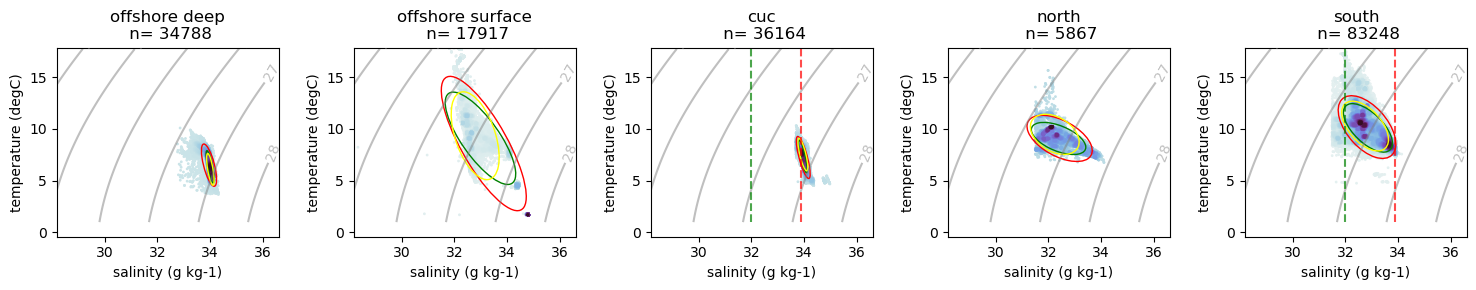

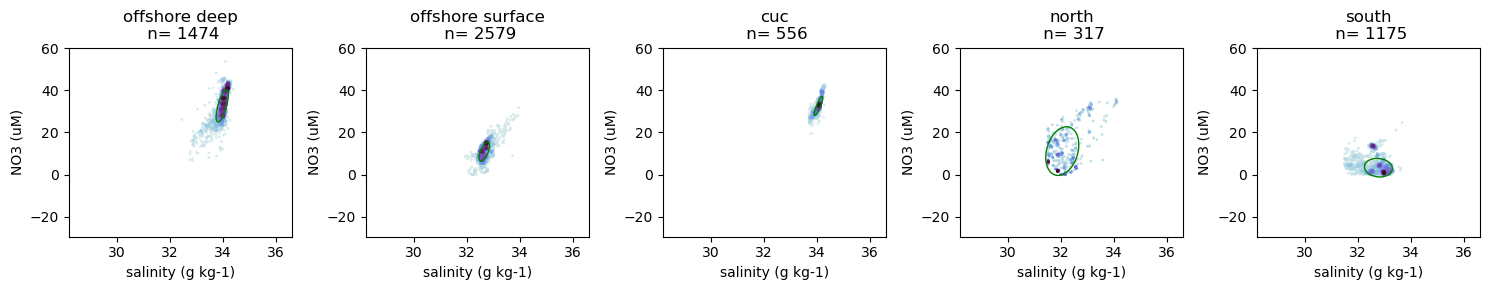

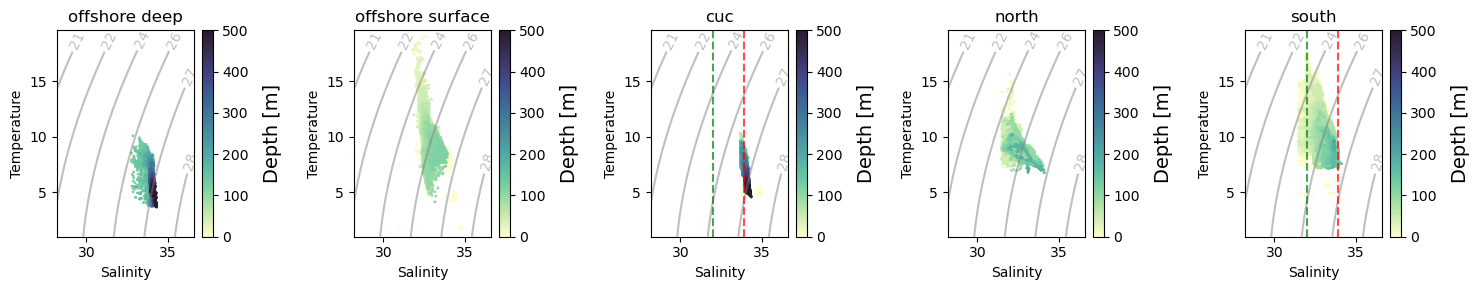

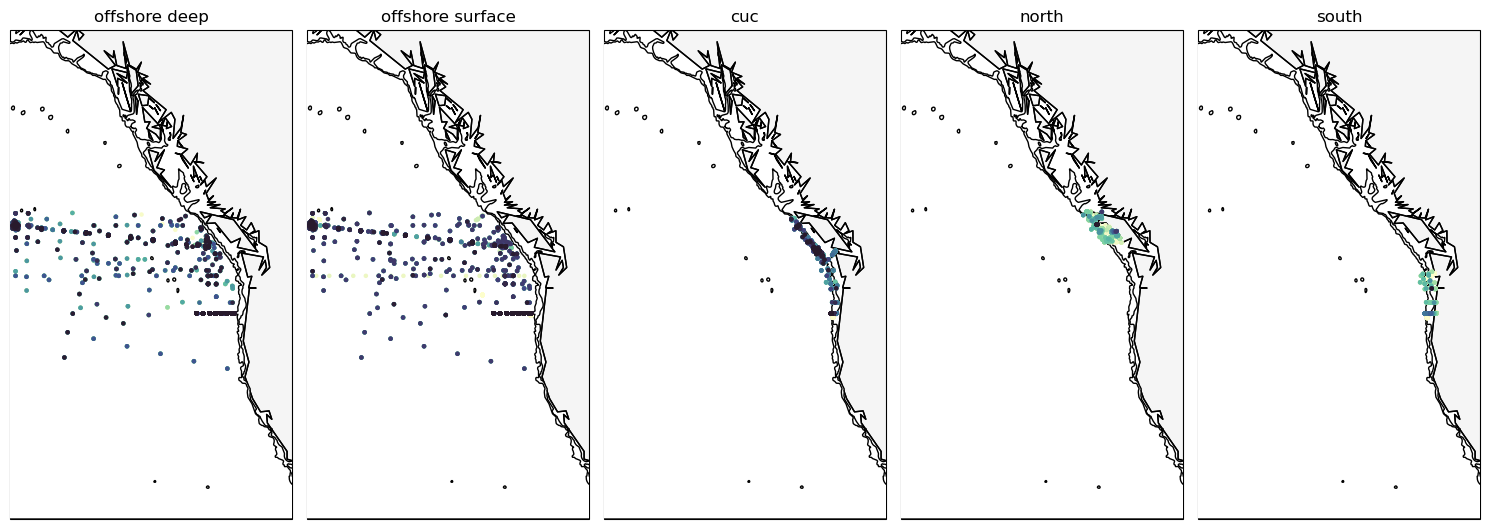

In [ ]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    ell = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, facecolor='none',edgecolor='green')
    ax[i].add_patch(ell)


# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ell = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['NO3 (uM)'][wob.region == regions[i]]), ax[i], percentile=50, facecolor='none', edgecolor='green')
    ax[i].add_patch(ell)
plt.tight_layout()

# TS coloured by depth
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS_depth(wob,regions[i],ax[i])

# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*3,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(wob,regions[i],ax[i])
plt.tight_layout()

NOTE: my summer and winter CUC definition overlaps well with ~40% PEW line (Newport - Vancouver Island Shelf) in figure 1 of Thomson and Krassovski (2010) for water between around 150-300 m deep

### Boxplots

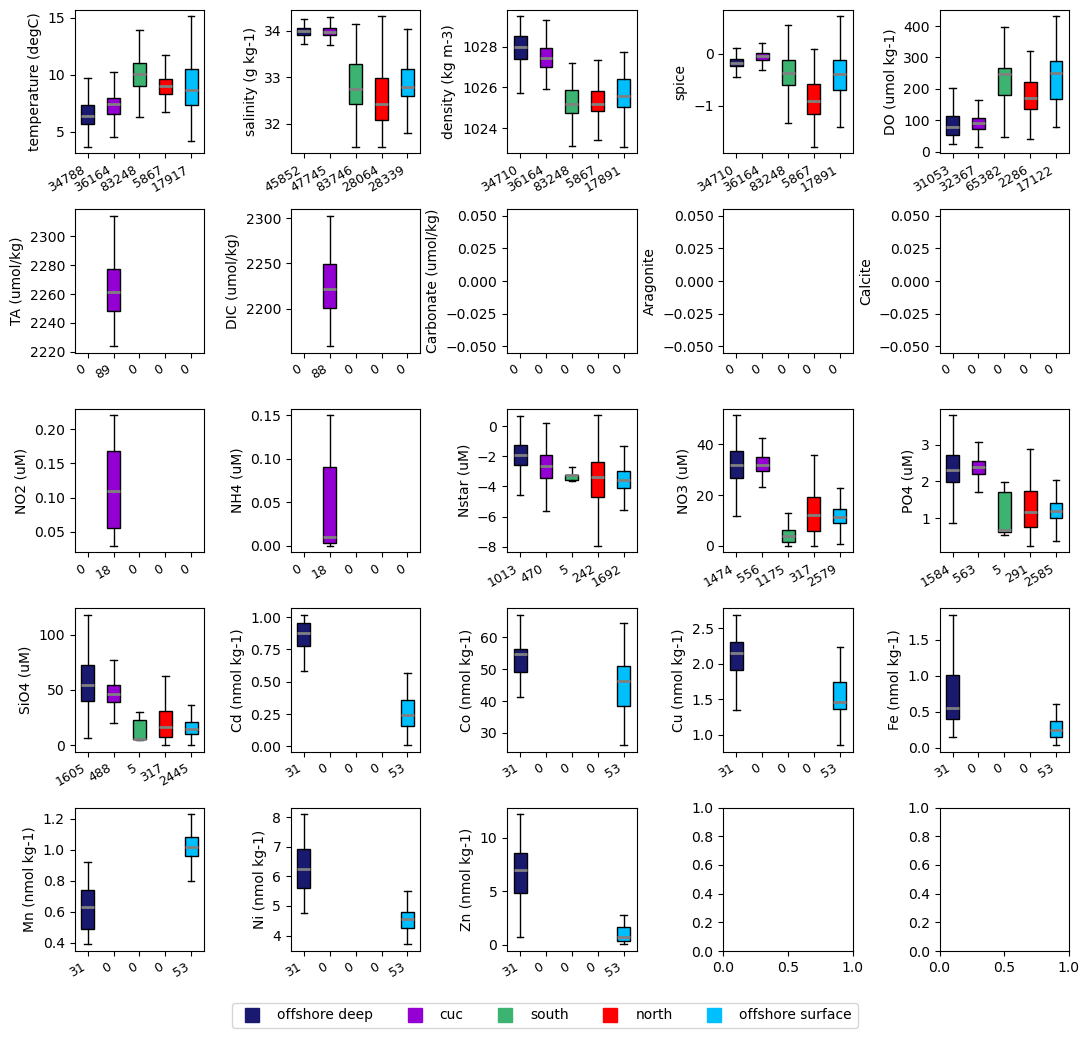

In [ ]:
# box plots of different tracers
regions = ['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
colour = ['midnightblue','darkviolet','mediumseagreen','red','deepskyblue']

fig, ax = plt.subplots(5,5,figsize=[11,10])

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[0,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['TA (umol/kg)','DIC (umol/kg)','Carbonate (umol/kg)','Aragonite', 'Calcite']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[1,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['NO2 (uM)','NH4 (uM)','Nstar (uM)','NO3 (uM)','PO4 (uM)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[2,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)


properties = ['SiO4 (uM)', 'Cd (nmol kg-1)','Co (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[3,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

properties = ['Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[4,i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

# build legend handles    
legend_handles = []
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=10,
                          markeredgecolor=colour[i], markerfacecolor=colour[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.001), frameon=True)

plt.tight_layout()
    


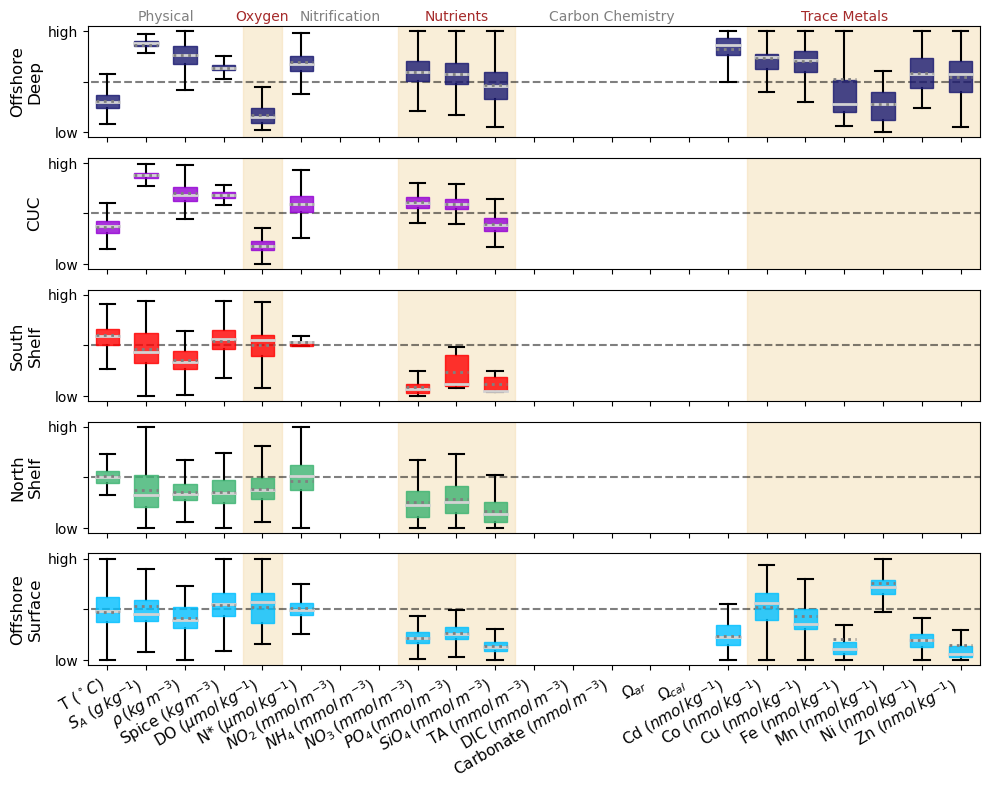

In [35]:
regions = ['offshore deep','cuc','south','north','offshore surface']
colour = ['midnightblue','darkviolet',  'r', 'mediumseagreen', 'deepskyblue']

data = wob
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)','Carbonate (umol/kg)','Aragonite', 'Calcite','Cd (nmol kg-1)','Co (nmol kg-1)',
              'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='lightgrey', linewidth=2,zorder=4)  # Median
        ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='grey', ls='dotted', linewidth=2,zorder=4)  # Mean

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              'N* ($\mu mol\,kg^{-1}$)','$NO_2\,(mmol\,m^{-3})$','$NH_4\,(mmol\,m^{-3})$','$NO_3\,(mmol\,m^{-3})$', '$PO_4\,(mmol\,m^{-3})$', '$SiO_4\,(mmol\,m^{-3})$', 'TA $(mmol\,m^{-3})$',
              'DIC $(mmol\,m^{-3})$', 'Carbonate $(mmol\,m^{-3})$','$\Omega_{ar}$', '$\Omega_{cal}$','Cd ($nmol\,kg^{-1}$)','Co ($nmol\,kg^{-1}$)',
              'Cu ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)','Mn ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=4.5)&(np.arange(0,len(properties)+1,0.5)>=0), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=8.5)&(np.arange(0,len(properties)+1,0.5)>=5.5), color='wheat', alpha=0.5, zorder=0)
    # ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=18)&(np.arange(0,len(properties)+1,0.5)>=11.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[0].set_ylabel('Offshore\nDeep',fontsize=12)
axes[1].set_ylabel('CUC',fontsize=12)
axes[2].set_ylabel('South\nShelf',fontsize=12)
axes[3].set_ylabel('North\nShelf',fontsize=12)
axes[4].set_ylabel('Offshore\nSurface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=10)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=10)
axes[0].text(7, 1.1, "Nitrification", ha='center', color='grey', fontsize=10)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=10)
axes[0].text(14, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=10)
axes[0].text(20, 1.1, "Trace Metals", ha='center', color='brown', fontsize=10)


plt.tight_layout()

### Statistics

In [36]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)', 'Carbonate (umol/kg)','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = wob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')



temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  p-adj   lower   upper  \
0               cuc             north    1.8445    0.0  1.7828  1.9063   
1               cuc     offshore deep   -0.7369    0.0 -0.7698 -0.7039   
2               cuc  offshore surface    1.3470    0.0  1.3069  1.3870   
3               cuc             south    2.9390    0.0  2.9114  2.9667   
4             north     offshore deep   -2.5814    0.0 -2.6433 -2.5195   
5             north  offshore surface   -0.4976    0.0 -0.5636 -0.4316   
6             north             south    1.0945    0.0  1.0353  1.1538   
7     offshore deep  offshore surface    2.0838    0.0  2.0435  2.1242   
8     offshore deep             south    3.6759    0.0  3.6479  3.7039   
9  offshore surface             south    1.5921    0.0  1.5560  1.6282   

   reject  Cohen's d       OVL  
0    True

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff   p-adj   lower   upper  \
0               cuc             north   -1.1029  0.0000 -1.1829 -1.0230   
1               cuc     offshore deep   -0.0630  0.0135 -0.1174 -0.0087   
2               cuc  offshore surface   -1.1823  0.0000 -1.2338 -1.1308   
3               cuc             south   -1.2898  0.0000 -1.7873 -0.7924   
4             north     offshore deep    1.0399  0.0000  0.9693  1.1106   
5             north  offshore surface   -0.0794  0.0136 -0.1478 -0.0109   
6             north             south   -0.1869  0.8458 -0.6864  0.3126   
7     offshore deep  offshore surface   -1.1193  0.0000 -1.1546 -1.0840   
8     offshore deep             south   -1.2268  0.0000 -1.7229 -0.7308   
9  offshore surface             south   -0.1075  0.9763 -0.6033  0.3882   

   reject  Cohen's d       OVL  
0    True   2.261355  0.258191  
1    True   0.154211  0.938540  
2    True   3.953712  0.

In [38]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'DO (umol kg-1)','Nstar (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'NO3 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(wob[prop][(wob.region == regions[0])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[0])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[1])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[1])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[2])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[2])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[3])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[3])]),1),
                np.round(np.nanmean(wob[prop][(wob.region == regions[4])]),1),np.round(np.nanstd(wob[prop][(wob.region == regions[4])]),1)))
    # print("\n")

['offshore deep', 'cuc', 'south', 'north', 'offshore surface']
temperature (degC) &6.5 (1.0) &7.2 (1.0) &10.2 (1.5) &9.1 (1.1) &8.6 (3.2) \
salinity (g kg-1) &34.0 (0.2) &34.0 (0.1) &32.8 (0.5) &32.6 (0.7) &33.0 (0.7) \
density (kg m-3) &1027.9 (0.7) &1027.5 (0.7) &1025.3 (0.7) &1025.3 (0.7) &1025.7 (1.0) \
spice &-0.2 (0.1) &-0.1 (0.1) &-0.4 (0.3) &-0.9 (0.4) &-0.4 (0.4) \
DO (umol kg-1) &86.9 (42.7) &90.5 (36.5) &224.5 (61.0) &176.3 (54.2) &230.7 (75.1) \
Nstar (uM) &-1.8 (1.3) &-2.7 (1.6) &-3.3 (0.3) &-3.9 (2.9) &-3.5 (1.0) \
NO2 (uM) &nan (nan) &0.1 (0.1) &nan (nan) &nan (nan) &nan (nan) \
NH4 (uM) &nan (nan) &0.2 (0.6) &nan (nan) &nan (nan) &nan (nan) \
NO3 (uM) &31.6 (7.4) &32.5 (4.1) &4.7 (4.1) &13.7 (9.5) &11.6 (4.3) \
PO4 (uM) &2.3 (0.5) &2.4 (0.3) &1.1 (0.6) &1.3 (0.6) &1.2 (0.3) \
SiO4 (uM) &56.4 (21.5) &48.0 (12.6) &13.6 (10.4) &19.7 (15.3) &16.0 (7.5) \
Chl (mg m-3) &0.1 (0.1) &0.0 (0.0) &1.4 (1.9) &1.5 (2.0) &0.7 (0.6) \
TA (umol/kg) &nan (nan) &2264.0 (19.4) &nan (nan) &

# winter summer compare

In [39]:
# add [TA-DIC] 
sob['[TA-DIC]'] = sob['TA (umol/kg)'] - sob['DIC (umol/kg)']
wob['[TA-DIC]'] = wob['TA (umol/kg)'] - wob['DIC (umol/kg)']
obs['[TA-DIC]'] = obs['TA (umol/kg)'] - obs['DIC (umol/kg)']


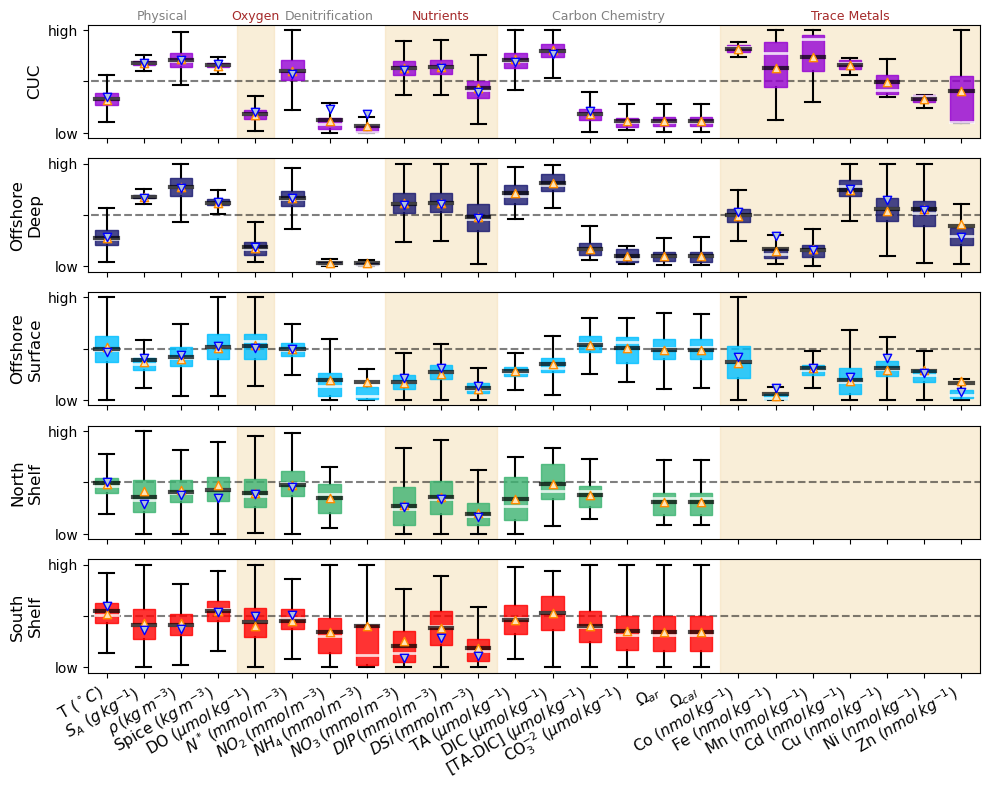

In [ ]:
regions = ['cuc','offshore deep','offshore surface','north','south']
colour = ['darkviolet','midnightblue', 'deepskyblue', 'mediumseagreen',   'r']

data = obs
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO2 (uM)','NH4 (uM)','NO3 (uM)','PO4 (uM)','SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)','[TA-DIC]', 'Carbonate (umol/kg)','Aragonite', 'Calcite','Co (nmol kg-1)','Fe (nmol kg-1)',
              'Mn (nmol kg-1)','Cd (nmol kg-1)','Cu (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']

# Function to calculate boxplot statistics
def calculate_boxplot_statistics(data, up, down,prop, region):
    region_data = data[data['region'] == region][prop].dropna()
    up_data = up[up['region'] == region][prop].dropna()
    down_data = down[down['region'] == region][prop].dropna()

    if len(region_data)>0:
        Q1 = np.percentile(region_data, 25)
        Q3 = np.percentile(region_data, 75)
        IQR = Q3 - Q1
        whisker_min = max(region_data.min(), Q1 - 1.5 * IQR)
        whisker_max = min(region_data.max(), Q3 + 1.5 * IQR)
        median = np.median(region_data)
        mean = np.mean(region_data)
        up_mean = np.mean(up_data)
        up_median = np.median(up_data)
        down_mean = np.mean(down_data)
        down_median = np.median(down_data)
    else:
        Q1 = np.nan
        Q3 = np.nan
        whisker_min = np.nan
        whisker_max = np.nan
        median = np.nan
        mean = np.nan
        up_mean = np.nan
        up_median = np.nan
        down_mean = np.nan
        down_median = np.nan
    return {
        'whisker_min': whisker_min,
        'Q1': Q1,
        'median': median,
        'mean': mean,
        'Q3': Q3,
        'whisker_max': whisker_max,
        'up_mean': up_mean,
        'up_median': up_median,
        'down_mean': down_mean,
        'down_median': down_median
    }

# Collect boxplot statistics for all regions and properties
boxplot_statistics = {prop: {region: calculate_boxplot_statistics(data, sob, wob, prop, region) for region in regions} for prop in properties}

# Normalize the statistics for plotting
normalized_statistics = {}
for prop in properties:
    # Gather all values to determine the global min and max for normalization
    all_values = []
    for region, statistics in boxplot_statistics[prop].items():
        all_values.extend([statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
                            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']])
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Normalize all statistics using the same range
    normalized_statistics[prop] = {
        region: {
            key: (value - global_min) / (global_max - global_min)
            for key, value in statistics.items()
        }
        for region, statistics in boxplot_statistics[prop].items()
    }

# Plot normalized boxplots manually
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 8), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    box_data = []
    for prop in properties:
        statistics = normalized_statistics[prop][region]
        box_data.append([
            statistics['whisker_min'], statistics['Q1'], statistics['median'], statistics['mean'], statistics['Q3'], statistics['whisker_max'],
            statistics['up_mean'], statistics['up_median'],statistics['down_mean'],statistics['down_median']
        ])
    
    # Manual construction of boxplot
    for j, statistics in enumerate(box_data):
        x = j + 1
        ax.plot([x, x], [statistics[0], statistics[1]], color='black',zorder=2)  # Lower whisker
        ax.plot([x, x], [statistics[4], statistics[5]], color='black',zorder=2)  # Upper whisker
        ax.plot([x - 0.2, x + 0.2], [statistics[0], statistics[0]], color='black',zorder=2)  # Lower cap
        ax.plot([x - 0.2, x + 0.2], [statistics[5], statistics[5]], color='black',zorder=2)  # Upper cap
        ax.add_patch(plt.Rectangle((x - 0.3, statistics[1]), 0.6, statistics[4] - statistics[1], color=colour[i], alpha=0.8,zorder=3))  # Box
        ax.plot([x - 0.3, x + 0.3], [statistics[2], statistics[2]], color='white', linewidth=2,zorder=4,alpha=0.8)  # Median
        ax.plot([x - 0.3, x + 0.3], [statistics[3], statistics[3]], color='black', alpha=0.7, linewidth=3,zorder=4)  # Mean
        ax.scatter(x, statistics[6], marker='^',c='moccasin',edgecolors='darkorange',zorder=4)  # upwelling mean
        ax.scatter(x, statistics[8], marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)  # downwelling mean
        # ax.plot(x, statistics[7], marker='*',color='orange', zorder=4)  # upwelling median
        # ax.plot(x, statistics[9], marker='*',color='blue', zorder=4)  # downwelling median

    
    ax.set_xticks(range(1, len(properties) + 1))
    prop_name = ['T ($^\circ C$)','$S_A$ ($g\,kg^{-1}$)',r'$\rho \,(kg\,m^{-3})$','Spice $(kg\,m^{-3})$','DO ($\mu mol\,kg^{-1}$)', 
              '$N^* \,(mmol\,m^{-3})$','$NO_2\,(mmol\,m^{-3})$','$NH_4\,(mmol\,m^{-3})$','$NO_3\,(mmol\,m^{-3})$', '$DIP\,(mmol\,m^{-3})$', '$DSi\,(mmol\,m^{-3})$', 'TA ($\mu mol\,kg^{-1}$)',
              'DIC ($\mu mol\,kg^{-1}$)', '[TA-DIC] ($\mu mol\,kg^{-1}$)', 'CO$_3^{-2}$ ($\mu mol\,kg^{-1}$)','$\Omega_{ar}$', '$\Omega_{cal}$','Co ($nmol\,kg^{-1}$)','Fe ($nmol\,kg^{-1}$)',
              'Mn ($nmol\,kg^{-1}$)', 'Cd ($nmol\,kg^{-1}$)','Cu ($nmol\,kg^{-1}$)','Ni ($nmol\,kg^{-1}$)', 'Zn ($nmol\,kg^{-1}$)']
    ax.set_xticklabels(prop_name,rotation=30,ha='right',fontsize=11)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['low',' ','high'])

    ax.set_xlim([0.5,len(properties)+0.5])
    ax.set_ylim([-0.05,1.05])
    ax.plot([0,len(properties)+1],[0.5,0.5],'k--',zorder=1,alpha=0.5)

    # tracer categories
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=5.5)&(np.arange(0,len(properties)+1,0.5)>=4.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=11.5)&(np.arange(0,len(properties)+1,0.5)>=8.5), color='wheat', alpha=0.5, zorder=0)
    ax.fill_between(np.arange(0,len(properties)+1,0.5), -0.1, 1.1, where=(np.arange(0,len(properties)+1,0.5)<=25.5)&(np.arange(0,len(properties)+1,0.5)>=17.5), color='wheat', alpha=0.5, zorder=0)



# region labels
axes[1].set_ylabel('Offshore\nDeep',fontsize=12)
axes[0].set_ylabel('CUC',fontsize=12)
axes[4].set_ylabel('South\nShelf',fontsize=12)
axes[3].set_ylabel('North\nShelf',fontsize=12)
axes[2].set_ylabel('Offshore\nSurface',fontsize=12)

# text above the top plot to label tracer categories
axes[0].text(2.5, 1.1, "Physical", ha='center', color='grey', fontsize=9)
axes[0].text(5, 1.1, "Oxygen", ha='center', color='brown', fontsize=9)
axes[0].text(7, 1.1, "Denitrification", ha='center', color='grey', fontsize=9)
axes[0].text(10, 1.1, "Nutrients", ha='center', color='brown', fontsize=9)
axes[0].text(14.5, 1.1, "Carbon Chemistry", ha='center', color='grey', fontsize=9)
axes[0].text(21, 1.1, "Trace Metals", ha='center', color='brown', fontsize=9)


plt.tight_layout()
plt.savefig('box.pdf')
plt.show()

In [41]:
all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'DO (umol kg-1)','Nstar (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'NO3 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (umol/kg)', 'DIC (umol/kg)', '[TA-DIC]', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

print(regions)
for prop in all_prop:
    # print in the same format as a latex table
    print('{} &{} ({}) &{} ({}) &{} ({}) &{} ({}) &{} ({}) \\'.format(prop,
                np.round(np.nanmean(obs[prop][(obs.region == regions[0])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[0])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[1])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[1])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[2])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[2])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[3])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[3])]),1),
                np.round(np.nanmean(obs[prop][(obs.region == regions[4])]),1),np.round(np.nanstd(obs[prop][(obs.region == regions[4])]),1)))
    # print("\n")

['cuc', 'offshore deep', 'offshore surface', 'north', 'south']
temperature (degC) &7.0 (0.9) &6.4 (1.1) &8.9 (3.2) &8.9 (1.6) &9.6 (1.8) \
salinity (g kg-1) &34.0 (0.1) &34.0 (0.2) &32.9 (0.6) &32.8 (0.7) &33.0 (0.6) \
density (kg m-3) &1027.6 (0.7) &1028.0 (0.7) &1025.6 (1.1) &1025.5 (0.9) &1025.5 (0.8) \
spice &-0.1 (0.1) &-0.2 (0.1) &-0.5 (0.4) &-0.7 (0.4) &-0.4 (0.3) \
DO (umol kg-1) &82.9 (33.2) &84.0 (41.3) &236.9 (71.9) &177.4 (76.1) &197.7 (78.2) \
Nstar (uM) &-2.4 (2.3) &-1.8 (1.5) &-3.5 (1.3) &-3.7 (2.8) &-3.9 (2.0) \
NO2 (uM) &0.1 (0.1) &0.0 (0.0) &0.1 (0.1) &0.2 (0.1) &0.2 (0.1) \
NH4 (uM) &0.1 (0.2) &0.0 (0.1) &0.2 (0.4) &nan (nan) &0.4 (0.8) \
NO3 (uM) &33.4 (5.2) &32.3 (6.9) &9.5 (5.9) &14.5 (11.0) &11.2 (10.5) \
PO4 (uM) &2.4 (0.4) &2.4 (0.5) &1.0 (0.4) &1.4 (0.7) &1.5 (0.8) \
SiO4 (uM) &52.4 (15.5) &57.8 (21.0) &14.2 (8.6) &23.6 (16.3) &22.4 (16.7) \
Chl (mg m-3) &0.0 (0.1) &0.1 (0.2) &0.8 (2.3) &3.6 (4.6) &2.6 (3.2) \
TA (umol/kg) &2268.7 (21.3) &2268.5 (24.0) &2180.7

In [42]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (uM)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (umol/kg)',
              'DIC (umol/kg)', '[TA-DIC]','Carbonate (umol/kg)','Aragonite', 'Calcite']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc             north    1.9403    True  -1.484364  0.457977
1               cuc     offshore deep   -0.6318    True   0.623754  0.755134
2               cuc  offshore surface    1.9422    True  -0.817867  0.682589
3               cuc             south    2.5575    True  -1.800133  0.368085
4             north     offshore deep   -2.5721    True   1.874821  0.348547
5             north  offshore surface    0.0019   False  -0.000754  0.999699
6             north             south    0.6172    True  -0.364006  0.855580
7     offshore deep  offshore surface    2.5741    True  -1.067624  0.593472
8     offshore deep             south    3.1893    True  -2.154168  0.281443
9  offshore surface             south    0.6152    True  -0.235839  0.906131


salinity

In [43]:
properties = ['NH4 (uM)', 'Carbonate (umol/kg)',]

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

NH4 (uM)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc     offshore deep   -0.0338   False   0.231739  0.907756
1               cuc  offshore surface    0.1126   False  -0.335193  0.866901
2               cuc             south    0.3468    True  -0.564250  0.777848
3     offshore deep  offshore surface    0.1464   False  -0.473709  0.812770
4     offshore deep             south    0.3806    True  -0.633958  0.751260
5  offshore surface             south    0.2342    True  -0.348413  0.861703


Carbonate (umol/kg)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  reject  Cohen's d       OVL
0               cuc     offshore deep   -1.7098   False   0.160607  0.935996
1               cuc  offshor

In [44]:
properties = ['Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)']

alpha = 0.05

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

Cd (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
          group1            group2  meandiff  reject  Cohen's d       OVL
0            cuc     offshore deep    0.0968   False  -0.757379  0.704918
1            cuc  offshore surface   -0.5122    True   3.768272  0.059547
2  offshore deep  offshore surface   -0.6091    True   3.770710  0.059382


Co (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
          group1            group2  meandiff  reject  Cohen's d       OVL
0            cuc     offshore deep  -28.4454    True   2.946333  0.140706
1            cuc  offshore surface  -39.8788    True   2.958278  0.139103
2  offshore deep  offshore surface  -11.4334    True   0.748480  0.708226


Cu (nmol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen'